## Demo  Experiment Tracking


In [16]:
import pandas as pd

df = pd.read_csv("airbnb-cleaned-mlflow.csv")

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop(["price"], axis=1), df[["price"]].values.ravel(), random_state=42)

%%sh
mkdir 02-experiment

In [18]:
import mlflow
from mlflow.exceptions import MlflowException
from  mlflow.tracking import MlflowClient

experimentPath = "02-experiment"

try:
  experimentID = mlflow.create_experiment(experimentPath)
except MlflowException:
  experimentID = MlflowClient().get_experiment_by_name(experimentPath).experiment_id
  mlflow.set_experiment(experimentPath)

print("The experiment can be found at the path `{}` and has an experiment_id of `{}`".format(experimentPath, experimentID))

The experiment can be found at the path `02-experiment` and has an experiment_id of `3`


In [19]:
import mlflow.sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

with mlflow.start_run(experiment_id=experimentID,run_name="Basic RF Experiment") as run:
  # Create model, train it, and create predictions
  rf = RandomForestRegressor()
  rf.fit(X_train, y_train)
  predictions = rf.predict(X_test)
  
  # Log model
  mlflow.sklearn.log_model(rf, "random-forest-model")
  
  # Create metrics
  mse = mean_squared_error(y_test, predictions)
  print("  mse: {}".format(mse))
  
  # Log metrics
  mlflow.log_metric("mse", mse)
  
  runID = run.info.run_uuid
  experimentID = run.info.experiment_id
  
  print("Inside MLflow Run with run_id {} and experiment_id {}".format(runID, experimentID))

  mse: 7291.517289719626
Inside MLflow Run with run_id c6ec9b6638154a94b541816707090a33 and experiment_id 3


In [9]:
from mlflow.tracking import MlflowClient

artifactURL = MlflowClient().get_experiment(experimentID).artifact_location
print(artifactURL)

/Users/azeltov/git/mlflowdemo/mlruns/3


In [11]:
%%sh
ls '/Users/azeltov/OneDrive - Microsoft/dev/python/mlflow/mlruns/3'

23359e1d350b48f5bd9bb74054736f6a
9e61bf6163f741f5af93775316101dc3
bd5e2c497a1345bb91f6fd67f47778dc
f3353851da05414eb3fd46d75d1fa240
meta.yaml


In [ ]:
%%sh
mkdir ml-production

## -------------------------------------------------------------------------------------------------------
## Demo  Experiment Tracking, provide run name and more detail metric logging example, with plots 

In [14]:
%matplotlib inline
def log_rf(experimentID, run_name, params, X_train, X_test, y_train, y_test):
  import os
  import matplotlib.pyplot as plt
  import mlflow.sklearn
  import seaborn as sns
  from sklearn.ensemble import RandomForestRegressor
  from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

  with mlflow.start_run(experiment_id=experimentID, run_name=run_name) as run:
    # Create model, train it, and create predictions
    rf = RandomForestRegressor(**params)
    rf.fit(X_train, y_train)
    predictions = rf.predict(X_test)

    # Log model
    mlflow.sklearn.log_model(rf, "random-forest-model")

    # Log params
    [mlflow.log_param(param, value) for param, value in params.items()]

    # Create metrics
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    print("  mse: {}".format(mse))
    print("  mae: {}".format(mae))
    print("  R2: {}".format(r2))

    # Log metrics
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("mae", mae)  
    mlflow.log_metric("r2", r2)  
    
    # Create feature importance
    importance = pd.DataFrame(list(zip(df.columns, rf.feature_importances_)), 
                                columns=["Feature", "Importance"]
                              ).sort_values("Importance", ascending=False)
    outdir = "./ml-production/"  
    csvPath = outdir + "feature-importance.csv"
    #csvPath = "feature-importance.csv"
    importance.to_csv(csvPath, index=False)
    mlflow.log_artifact(csvPath)

    # Create and lot plot
    fig, ax = plt.subplots()

    sns.residplot(predictions, y_test, lowess=True)
    plt.xlabel("Predicted values for Price ($)")
    plt.ylabel("Residual")
    plt.title("Residual Plot")

    figPath =  outdir + "residuals.png" 
    fig.savefig(figPath)

    mlflow.log_artifact(figPath)
    plt.show()
    
    return run.info.run_uuid

  mse: 7026.790895355779
  mae: 54.378623517456184
  R2: 0.6568907256484691


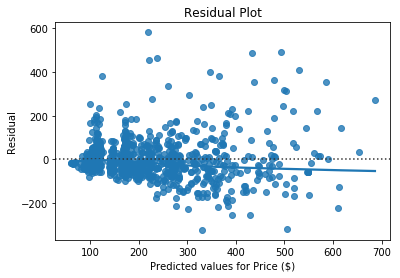

'ff4c45520a4d4ea29aa161efce7d98b4'

In [15]:
%matplotlib inline

params = {
  "n_estimators": 100,
  "max_depth": 5,
  "random_state": 42
}

log_rf(experimentID, "Second Run 0513", params, X_train, X_test, y_train, y_test)

  mse: 6013.392655867829
  mae: 48.82972063589866
  R2: 0.7063736745163001


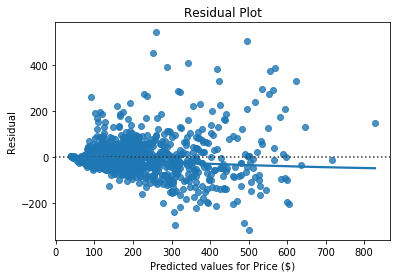

'b65e93dba98b41dba1b4a3d03d41ac58'

In [24]:
params_1000_trees = {
  "n_estimators": 1000,
  "max_depth": 10,
  "random_state": 42
}

log_rf(experimentID, "Third Run", params_1000_trees, X_train, X_test, y_train, y_test)

In [27]:
from  mlflow.tracking import MlflowClient

client = MlflowClient()

In [28]:
runs = pd.DataFrame([(run.run_uuid, run.start_time, run.artifact_uri) for run in client.list_run_infos(experimentID)])
runs.columns = ["run_uuid", "start_time", "artifact_uri"]

print(runs)

                           run_uuid     start_time  \
0  75e13a9dcaea4caaa308dd18986fa983  1557331381443   
1  739c8e2d77434d4c91574d8a839cc244  1557329018745   
2  b65e93dba98b41dba1b4a3d03d41ac58  1557331444036   

                                        artifact_uri  
0  /Users/azeltov/OneDrive - Microsoft/dev/python...  
1  /Users/azeltov/OneDrive - Microsoft/dev/python...  
2  /Users/azeltov/OneDrive - Microsoft/dev/python...  


## Use AML to build images and deploy

In [5]:
import mlflow
import mlflow.sklearn
import azureml.contrib.mlflow
import azureml.core
from azureml.core import Workspace
import matplotlib.pyplot as plt

# Check core SDK version number
import azureml.core

print("SDK version:", azureml.core.VERSION)

SDK version: 1.0.33


In [6]:
ws = Workspace.from_config()



If you run your code in unattended mode, i.e., where you can't give a user input, then we recommend to use ServicePrincipalAuthentication or MsiAuthentication.
Please refer to aka.ms/aml-notebook-auth for different authentication mechanisms in azureml-sdk.


In [ ]:
import mlflow.azureml

model_image, azure_model = mlflow.azureml.build_image(model_path=model_path, 
                                                      workspace=workspace, 
                                                      run_id=run_id1,
                                                      model_name="wine-model",
                                                      image_name="wine-model",
                                                      description="Sklearn ElasticNet image for rating wines", 
                                                      tags={
                                                        "alpha": str(alpha_1),
                                                        "l1_ratio": str(l1_ratio_1),
                                                      },
                                                      synchronous=False)